# Part 1
## Using GradCAM to visualize where the network is focusing

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/EVA/Assgn 9")

In [3]:
# Holy Mantras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# we have taken this function from here: https://github.com/yu4u/cutout-random-erasing
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_value=None, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break
        
        if any(pixel_value):
            c = pixel_value
        elif pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [5]:
# Keras provides the option to download the CIFAR10 dataset using its API
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape

# CIFAR 10 dataset has 10 unique classes 
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


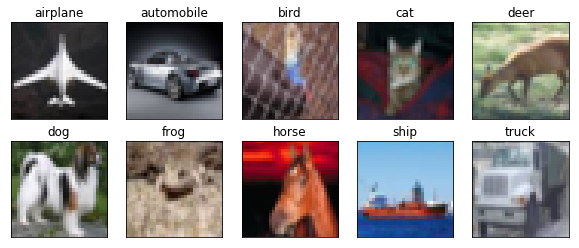

In [6]:
# class_names contain the 10 names for 10 unique classes
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

'''
We should always look at some sample of images before constructing any model
as it helps in determinig the size of final receptive field, placement of first
pool layer in the network.
'''
fig = plt.figure(figsize=(10,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# preserving the class numbers before doing one-hot encoding
train_labels_cat, test_labels_cat = train_labels, test_labels
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# normalising the training and test data
train_features_mean = np.mean(train_features.astype('float32'), axis=(0,1,2))
train_features_std = np.std(train_features.astype('float32'), axis=(0,1,2))
train_features_norm = (train_features-train_features_mean)/train_features_std
test_features_norm = (test_features-train_features_mean)/train_features_std

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, padding='same', input_shape=(32, 32, 3))) # rf: 3, os: 32x32
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(64, 3, padding='same')) # rf: 5, os: 32x32
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, padding='same')) # rf: 7, os: 32x32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # rf: 8, os: 16x16

model.add(Convolution2D(32, 1)) # rf: 8, os: 16x16
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(64, 3, padding='same')) # rf: 12, os: 16x16
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, padding='valid')) # rf: 16, os: 14x14
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # rf: 18, os: 7x7

model.add(Convolution2D(32, 1)) # rf: 18, os: 7x7
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(10, 7)) # rf: 42, os: 1x1
model.add(Flatten())
model.add(Activation('softmax'))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)       

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# using learning rate scheduler to decrease the learning gradulally as the 
# number of epochs increases

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(filepath='model.{epoch:02d}-{val_acc:.2f}.h5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             period=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`


Epoch 1/50
391/390 [==============================] - 29s 74ms/step - loss: 1.5809 - acc: 0.4234 - val_loss: 1.8921 - val_acc: 0.4224
Epoch 2/50
391/390 [==============================] - 24s 62ms/step - loss: 1.2484 - acc: 0.5481 - val_loss: 1.0830 - val_acc: 0.6251
Epoch 3/50
391/390 [==============================] - 24s 62ms/step - loss: 1.0976 - acc: 0.6087 - val_loss: 1.4235 - val_acc: 0.5709
Epoch 4/50
391/390 [==============================] - 24s 63ms/step - loss: 0.9993 - acc: 0.6457 - val_loss: 0.9261 - val_acc: 0.6909
Epoch 5/50
391/390 [==============================] - 24s 62ms/step - loss: 0.9298 - acc: 0.6712 - val_loss: 0.9025 - val_acc: 0.6986

Epoch 00005: val_acc improved from -inf to 0.69860, saving model to model.05-0.70.h5
Epoch 6/50
391/390 [==============================] - 24s 62ms/step - loss: 0.8777 - acc: 0.6939 - val_loss: 0.8341 - val_acc: 0.7203
Epoch 7/50
391/390 [==============================] - 24s 62ms/step - loss: 0.8375 - acc: 0.7054 - val_loss: 0

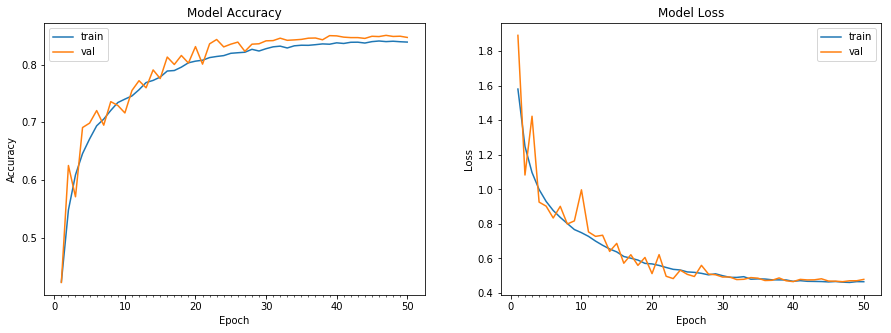

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Using data augmentation techniques to generalise the model further 
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(train_features)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features_norm, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]/128, nb_epoch = 50, 
                                 validation_data = (test_features_norm, test_labels), 
                                 verbose=1, callbacks=[lr_scheduler, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

We can observe that the model is regularised and we don't see overfitting till the end

In [0]:
import numpy as np
import cv2

In [11]:
from keras.models import load_model

model = load_model("noncutout_model.40-0.85.h5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# function to get the gradcam image
def gradcam(org_img, layer, model):
    x = np.expand_dims(org_img, axis=0)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(32):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
        
    heatmap = cv2.resize(heatmap, (org_img.shape[1], org_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return superimposed_img    

In [13]:
# predictions for test images
test_preds = model.predict(test_features_norm, batch_size=32, verbose=1)
test_preds.shape

10000/10000 [==============================] - 5s 522us/step


(10000, 10)

In [14]:
# getting classes for the predictions
test_preds_class = np.argmax(test_preds, axis=1)
test_preds_class = np.expand_dims(test_preds_class, axis=1)
test_preds_class.shape, test_labels_cat.shape

((10000, 1), (10000, 1))

In [0]:
# getting the index of correctly classfied and misclassified images
correct_classified_index = np.where(test_labels_cat == test_preds_class) # returns a tuple 
misclassified_index = np.where(test_labels_cat != test_preds_class) # returns a tuple

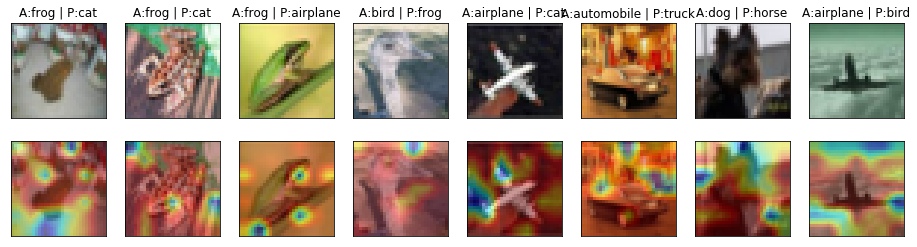

In [64]:
# we have chosen these indices for images after examining a lot of images 
# which clearly show improvements in gradcam activations upon using cutout
display_indices = [59, 95, 112, 266, 423, 439, 518, 473]
fig = plt.figure(figsize=(16,4))
for i in range(len(display_indices)):
    ax1 = fig.add_subplot(2, 8, 1 + i, xticks=[], yticks=[])
    ax2 = fig.add_subplot(2, 8, 9 + i, xticks=[], yticks=[])
    idx = display_indices[i]
    img = test_features[idx, :]
    gradcam_img = test_features_norm[idx, :]
    superimposed_img = gradcam(gradcam_img, layer="conv2d_7", model=model) 
    actual_class = class_names[test_labels_cat[idx][0]]
    predicted_class = class_names[test_preds_class[idx][0]]
    title = f'A:{actual_class} | P:{ predicted_class}'
    ax1.set_title(title)
    ax1.imshow(img)
    ax2.imshow(superimposed_img)

# Part 2
## Using CutOut for Image Augmentation

In [0]:
# first we will visulaise how cutout changes the images  
from keras.preprocessing.image import ImageDataGenerator 
'''
we will use the mean of the normalised features as pixel value for the cutout
region.
'''
normalised_features_mean = np.mean(train_features_norm, axis=(0,1,2))
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_value=normalised_features_mean))

datagen.fit(train_features_norm)
train_iterator = datagen.flow(train_features_norm, train_labels_cat, batch_size=128, shuffle=False)
X_cutout, y_cutout = train_iterator.next()

In [18]:
''' 
we will see a bit of difference here in the mean values even though we 
replaced the cutout region with the mean of pixel values in the normalised training 
features. That's because for the images with cutout, we are taking the mean of a 
batch of 128 images
'''

print("Mean of the normalised features", normalised_features_mean)
print("Mean of the images with cutout region", np.mean(X_cutout, axis=(0,1,2)))

Mean of the normalised features [ 2.9031128e-07  3.9386641e-06 -9.1979691e-06]
Mean of the images with cutout region [-0.00501636 -0.02844516 -0.03978906]


In [0]:
# we will need to denormalise the images before we plot them
def denormalize_image(X):
    return np.int16(X*train_features_std + train_features_mean)

In [20]:
X_cutout_denormalised = denormalize_image(X_cutout)
print("Mean of the original training images", train_features_mean)
print("Mean of the denormalised training images with cutout", np.mean(X_cutout_denormalised, axis=(0,1,2)))

Mean of the original training images [125.3069  122.95015 113.866  ]
Mean of the denormalised training images with cutout [124.96795654 121.12827301 111.16105652]


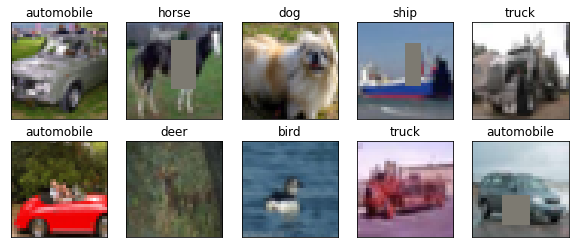

In [66]:
# we can see a grey rectangular area in some images as we are not putting cutout on all images 
fig = plt.figure(figsize=(10,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    np.random.seed(i)
    idx = np.random.randint(0,128, 1)[0]
    img = X_cutout_denormalised[idx,::]
    category = class_names[y_cutout[idx,0]]
    ax.set_title(category)
    plt.imshow(img)
plt.show()

In [0]:
# Redefing the model by removing the dropout layers otherwise the model doesn't perform well 
# due to too much regularization

model = Sequential()
model.add(Convolution2D(32, 3, padding='same', input_shape=(32, 32, 3))) # rf: 3, os: 32x32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, padding='same')) # rf: 5, os: 32x32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, padding='same')) # rf: 7, os: 32x32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # rf: 8, os: 16x16

model.add(Convolution2D(32, 1)) # rf: 8, os: 16x16
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, padding='same')) # rf: 12, os: 16x16
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, padding='valid')) # rf: 16, os: 14x14
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # rf: 18, os: 7x7

model.add(Convolution2D(32, 1)) # rf: 18, os: 7x7
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(10, 7)) # rf: 42, os: 1x1
model.add(Flatten())
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)      

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam, SGD

# Compile the model
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# using learning rate scheduler to decrease the learning gradulally as the 
# number of epochs increases

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(filepath='cutout_model.{epoch:02d}-{val_acc:.2f}.h5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             period=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=150)`
  app.launch_new_instance()


Epoch 1/150
391/390 [==============================] - 47s 119ms/step - loss: 1.6104 - acc: 0.4151 - val_loss: 1.3636 - val_acc: 0.5351
Epoch 2/150
391/390 [==============================] - 43s 109ms/step - loss: 1.2683 - acc: 0.5424 - val_loss: 1.7848 - val_acc: 0.5016
Epoch 3/150
391/390 [==============================] - 43s 110ms/step - loss: 1.1192 - acc: 0.6040 - val_loss: 1.0575 - val_acc: 0.6574
Epoch 4/150
391/390 [==============================] - 43s 110ms/step - loss: 1.0331 - acc: 0.6351 - val_loss: 1.3247 - val_acc: 0.5991
Epoch 5/150
391/390 [==============================] - 43s 110ms/step - loss: 0.9662 - acc: 0.6581 - val_loss: 1.5790 - val_acc: 0.5804

Epoch 00005: val_acc improved from -inf to 0.58040, saving model to cutout_model.05-0.58.h5
Epoch 6/150
391/390 [==============================] - 43s 110ms/step - loss: 0.9130 - acc: 0.6767 - val_loss: 1.5659 - val_acc: 0.6078
Epoch 7/150
391/390 [==============================] - 43s 110ms/step - loss: 0.8726 - acc:

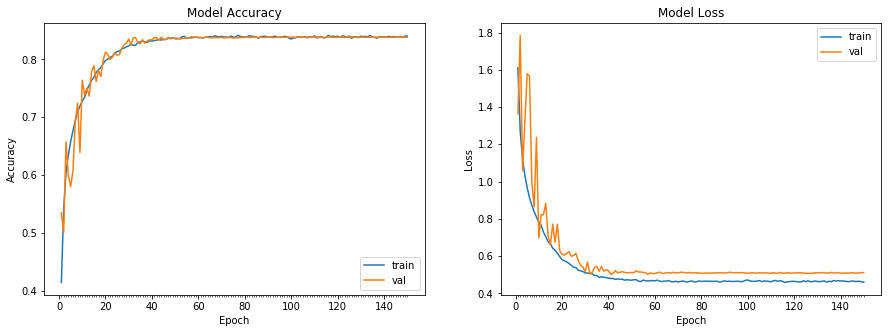

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# Using Cut-out for data augmentation along with other image augmentation strategies 
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_value=normalised_features_mean),
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(train_features_norm)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features_norm, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]/128, nb_epoch = 150, 
                                 validation_data = (test_features_norm, test_labels), 
                                 verbose=1, callbacks=[lr_scheduler, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

The results are slightly worse than when we were using dropout.

In [0]:
# loading the best keras model
from keras.models import load_model 
cutout_model = load_model("cutout_model.105-0.84.h5")

In [28]:
# getting the prediction for this model and index for correctly classified 
# and misclassified images
cutout_test_preds = cutout_model.predict(test_features_norm, batch_size=32, verbose=1)
cutout_test_preds_class = np.argmax(cutout_test_preds, axis=1)
cutout_test_preds_class = np.expand_dims(cutout_test_preds_class, axis=1)
print(cutout_test_preds_class.shape, test_labels_cat.shape)
cutout_correct_classified_index = np.where(test_labels_cat == cutout_test_preds_class) # returns a tuple 
cutout_misclassified_index = np.where(test_labels_cat != cutout_test_preds_class) # returns a tuple

10000/10000 [==============================] - 3s 317us/step
(10000, 1) (10000, 1)


In [52]:
# we are finding those indices which are correctly classified by the cutout model
# so that we have higher chance of observing correct gradcam activations
corrected_by_cutout = [i for i in misclassified_index[0] if i not in cutout_misclassified_index[0]]
corrected_by_cutout[:10]

[59, 95, 112, 143, 150, 171, 178, 195, 242, 245]

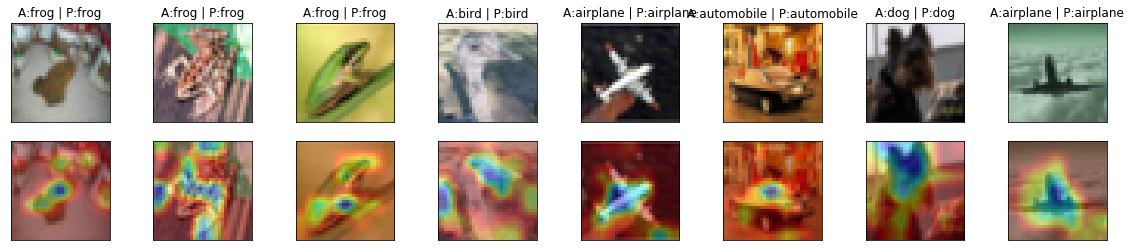

In [68]:
fig = plt.figure(figsize=(20,4))
for i in range(len(display_indices)):
    ax1 = fig.add_subplot(2, 8, 1 + i, xticks=[], yticks=[])
    ax2 = fig.add_subplot(2, 8, 9 + i, xticks=[], yticks=[])
    idx = display_indices[i]
    img = test_features[idx, :]
    gradcam_img = test_features_norm[idx, :]
    superimposed_img = gradcam(gradcam_img, layer="conv2d_23", model=cutout_model) 
    actual_class = class_names[test_labels_cat[idx][0]]
    predicted_class = class_names[cutout_test_preds_class[idx][0]]
    title = f'A:{actual_class} | P:{ predicted_class}'
    ax1.set_title(title)
    ax1.imshow(img)
    ax2.imshow(superimposed_img)

We can clearly see these activations are focusing on the object as compared to the ones where we didn't use gradcam.